In [1]:
import os
import re
import pandas as pd
import tensorflow as tf
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Flatten,Dense,Embedding
from keras import models, layers, optimizers, losses, metrics
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers.convolutional  import  Convolution1D, MaxPooling1D
from keras.layers import LSTM
from keras.callbacks import LambdaCallback
tok = Tokenizer()

Using TensorFlow backend.


In [3]:
train_pos=[]
train_neg=[]
test_pos=[]
test_neg=[]

In [4]:
#imput data and make train_test_split
def train_test_split(file_root):
    train = []
    test = []
    for file_root, _, file in os.walk(file_root):
        for f in file:
                index = int(re.findall("\d+", f)[0])
                file_path = os.path.join(file_root, f)
                name = os.path.split(file_root)[-1]
                if (index > 699):
                    test.append(file_path)
                else:
                    train.append(file_path)
    return train, test

In [5]:
#remove the punctuation
def remove(text):
    remove_chars = '[0-9’!"#$%&\'()*+,-./:;<=>?@，。?★、…【】《》？“”‘’！[\\]^_`{|}~]+'
    return re.sub(remove_chars, '', text)

In [6]:
train_pos,test_pos=train_test_split('../Data/pos')
train_neg,test_neg=train_test_split('../Data/neg')

In [7]:
#remove \n and combine all the string
stri=[]#the box to hold all the words

In [8]:
def remove_combine(data):
    for i in range(0,len(data)):
        f=open(data[i],'r')
        st=f.read()
        f.close()
        st=remove(st)
        st=st.replace('\n','').replace('\r','')
        stri.append(st)

In [9]:
#combine
remove_combine(train_pos)
remove_combine(test_pos)
remove_combine(train_neg)
remove_combine(test_neg)
#print(stri)
tok.fit_on_texts(stri)
#print(tok.word_counts)
all_words=len(tok.word_counts)
print('All words is',all_words)

All words is 46830


In [10]:
#show result
review_len=[]
for a in range(0,len(stri)):
    st_new=stri[a]
    st_new=st_new.split()
    review_len.append(len(st_new))
df_review_len=pd.DataFrame(review_len,columns=['length'])
print('The average length of review is',df_review_len.mean().values[0])
print('The std of review is',df_review_len.std().values[0])

The average length of review is 644.361
The std of review is 285.0598064014157


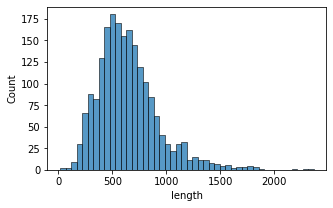

In [11]:
plt.figure(figsize=(5,3))
sns.histplot(data=df_review_len, x='length')
plt.show()

In [28]:
#data transfrom
data_trans=tok.texts_to_sequences(stri)
df_review_len_sort=df_review_len.sort_values(by='length')
max_num=df_review_len_sort.iloc[int(len(review_len)*0.9),:].values[0] #choose max_length
data_trans_true=pad_sequences(data_trans,maxlen=max_num,padding ='post',truncating='post')
print(data_trans_true)

[[  98 2272 8121 ...    0    0    0]
 [  61   65 1967 ...    0    0    0]
 [   1   66    4 ...    0    0    0]
 ...
 [1385 2280    6 ...    0    0    0]
 [ 152 4698   30 ...    0    0    0]
 [  23  685    5 ...    0    0    0]]


In [29]:
#train_test_split
df_raw_data=pd.DataFrame(data_trans_true)
x_train1=df_raw_data.iloc[:700,:]
x_test1=df_raw_data.iloc[700:1000,:]
x_train2=df_raw_data.iloc[1000:1700,:]
x_test2=df_raw_data.iloc[1700:,:]
x_train=pd.concat([x_train1,x_train2])
x_test=pd.concat([x_test1,x_test2])
x_train=pd.DataFrame(x_train.values)
x_test=pd.DataFrame(x_test.values)
x_train[x_train>=5000]=0
x_test[x_test>=5000]=0
y_train1=list(1 for i in range(1,701))
y_train2=list(-1 for i in range(1,701))
y_train=y_train1+y_train2
y_test1=list(1 for i in range(1,301))
y_test2=list(-1 for i in range(1,301))
y_test=y_test1+y_test2

In [30]:
#mix up train_data
indices=np.arange(x_train.shape[0])
np.random.shuffle(indices)
y_train=pd.DataFrame(y_train)
x_train=x_train.loc[indices]
y_train=y_train.loc[indices]
x_train=x_train.values
x_test=x_test.values

In [17]:
#mlp
def mlp(opt='adam'):
    model = Sequential()
    model.add(Embedding(5001, 32, input_length=max_num))
    model.add(Flatten())
    model.add(Dropout(rate=0.2))
    model.add(Dense(units=50, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=50, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=50, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [22]:
def acc_result(x_tr,x_te,y_tr,y_te,classifier,num_epochs):
    mlp_model = KerasClassifier(build_fn=classifier, epochs=num_epochs, batch_size=10)
    mlp_model.fit(x_tr,y_tr)
    y_train_predict_mlp = mlp_model.predict(x_tr)
    y_test_predict_mlp = mlp_model.predict(x_te)
    train_acc = accuracy_score(y_tr,y_train_predict_mlp)
    test_acc = accuracy_score(y_te,y_test_predict_mlp)
    return train_acc, test_acc,y_train_predict_mlp,y_test_predict_mlp

In [23]:
#print the result of mlp
mlp_train_acc,mlp_test_acc,y_p_train_mlp,y_p_test_mlp= acc_result(x_train,x_test,y_train,y_test,mlp,2)
print('Using mlp models, the train set accuracy is:{}, the test set accuracy is {}.'.
      format(round(mlp_train_acc,4),round(mlp_test_acc,4)))

Epoch 1/2
1400/1400 [==============================] - 9s 6ms/step - loss: 0.6991 - accuracy: 0.5029
Epoch 2/2
1400/1400 [==============================] - 7s 5ms/step - loss: 0.6873 - accuracy: 0.5350
Using mlp models, the train set accuracy is:0.7193, the test set accuracy is 0.54.


In [26]:
#CNN
def CNN(opt='adam'):
    model = Sequential()
    model.add(Embedding(5001, 32, input_length=max_num))
    model.add(Convolution1D(32,3,activation='relu'))
    model.add(MaxPooling1D(strides=2,pool_size=2))
    model.add(Flatten())
    model.add(Dropout(rate=0.2))
    model.add(Dense(units=50, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=50, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=50, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [27]:
cnn_train_acc,cnn_test_acc,y_p_train_cnn,y_p_test_cnn=acc_result(x_train,x_test,y_train,y_test,CNN,2)
print('Using cnn models, the train accuracy is:{}, the test accuracy is {}.'.format(round(cnn_train_acc,4),round(cnn_test_acc,4)))

Epoch 1/2
1400/1400 [==============================] - 9s 7ms/step - loss: 0.6966 - accuracy: 0.5014
Epoch 2/2
1400/1400 [==============================] - 7s 5ms/step - loss: 0.6922 - accuracy: 0.5293
Using cnn models, the train accuracy is:0.6521, the test accuracy is 0.5633.


In [31]:
#LSTM
def LSTM_model(opt='adam'):
    model = Sequential()
    model.add(Embedding(5001, 32, input_length=max_num))
    #model.add(Dropout(rate=0.2))
    model.add(LSTM(32, return_sequences=True,activation='relu',dropout=0.2))
    model.add(Flatten())
    model.add(Dropout(rate=0.2))
    model.add(Dense(units=256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(units=1, activation='sigmoid'))
    adam_optimizer = Adam(lr=0.0001, beta_1=0.5)
    model.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
train_test_acc=[]
lstm_iter_model=KerasClassifier(build_fn=LSTM_model, epochs=50, batch_size=10)
save_point=LambdaCallback(on_epoch_end=lambda epochs,logs:train_test_acc.append([accuracy_score(y_train,lstm_iter_model.predict(x_train)),
                                                                                 accuracy_score(y_test,lstm_iter_model.predict(x_test))]))
lstm_iter_model.fit(x_train,y_train,callbacks=[save_point])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
2022-05-10 10:08:06.039033: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-10 10:08:06.039551: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Epoch 1/50
1400/1400 [==============================] - 550s 393ms/step - loss: 0.6953 - accuracy: 0.5093
Epoch 2/50
 710/1400 [==============>...............] - ETA: 5:51 - loss: 0.6869 - accuracy: 0.5577

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/virgil_lee/Downloads/anaconda/anaconda3/envs/untitled2/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/9g/15wmnj2j4913201hs60_m1sh0000gn/T/ipykernel_74337/344838209.py", line 5, in <module>
    lstm_iter_model.fit(x_train,y_train,callbacks=[save_point])
  File "/Users/virgil_lee/Downloads/anaconda/anaconda3/envs/untitled2/lib/python3.7/site-packages/keras/wrappers/scikit_learn.py", line 209, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "/Users/virgil_lee/Downloads/anaconda/anaconda3/envs/untitled2/lib/python3.7/site-packages/keras/wrappers/scikit_learn.py", line 151, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/Users/virgil_lee/Downloads/anaconda/anaconda3/envs/untitled2/lib/python3.7/site-packages/keras/engine/training.py", line 1239, in fit
    validation_freq=validation_freq)


In [ ]:
df_lstm=pd.DataFrame(train_test_acc,columns=['train_acc','test_acc'])
epoch=np.arange(1,len(df_lstm)+1)
df_lstm.index=epoch
print(df_lstm)
plt.figure(figsize=(10,5))
plt.plot(epoch,df_lstm['train_acc'],c='r',label='train_set_accuracy')
plt.plot(epoch,df_lstm['test_acc'],c='b',label='test_set_accuracy')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend()
plt.show(